In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/clouds-ml/src
from config import *
# !python extract.py

/content/drive/MyDrive/clouds-ml/src


In [4]:
import pandas as pd
df = pd.read_csv(f'{DATA_PROCESSED}/main.csv')

In [5]:
print(f"Dataset size: {len(df)} images")
print(f"Head: \n{df.head(10)}")

Dataset size: 1000 images
Head: 
   Unnamed: 0                                          photo_url direction  \
0           0  https://data.globe.gov/system/photos/2025/09/0...         N   
1           1  https://data.globe.gov/system/photos/2025/09/0...         E   
2           2  https://data.globe.gov/system/photos/2025/09/0...         S   
3           3  https://data.globe.gov/system/photos/2025/09/0...         W   
4           4  https://data.globe.gov/system/photos/2025/09/0...         U   
5           5  https://data.globe.gov/system/photos/2025/09/0...         N   
6           6  https://data.globe.gov/system/photos/2025/09/0...         E   
7           7  https://data.globe.gov/system/photos/2025/09/0...         S   
8           8  https://data.globe.gov/system/photos/2025/09/0...         W   
9           9  https://data.globe.gov/system/photos/2025/09/0...         U   

                             obs_id    user_id  altocumulus  altostratus  \
0   116-52378-24905746-202509011

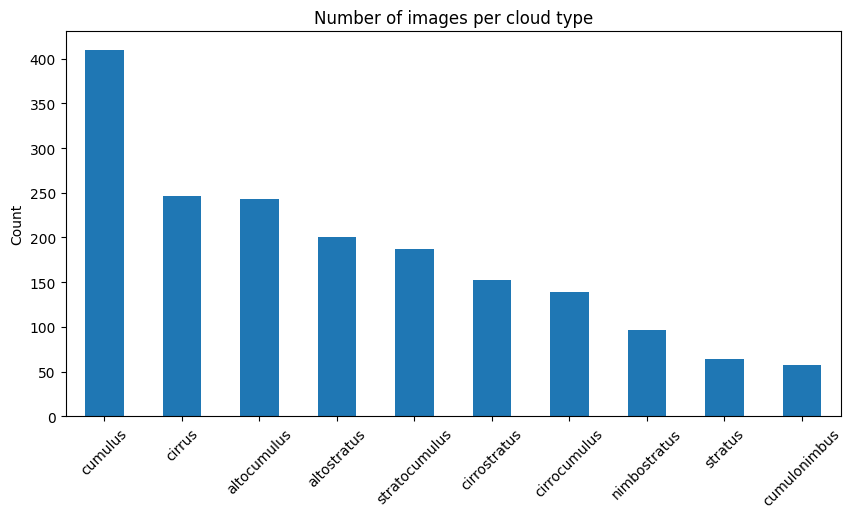

In [6]:
import matplotlib.pyplot as plt
CLOUD_COLS = [
  "altocumulus",
  "altostratus",
  "cirrocumulus",
  "cirrostratus",
  "cirrus",
  "cumulonimbus",
  "cumulus",
  "nimbostratus",
  "stratocumulus",
  "stratus"
]
label_counts = df[CLOUD_COLS].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
label_counts.plot(kind="bar")
plt.title("Number of images per cloud type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

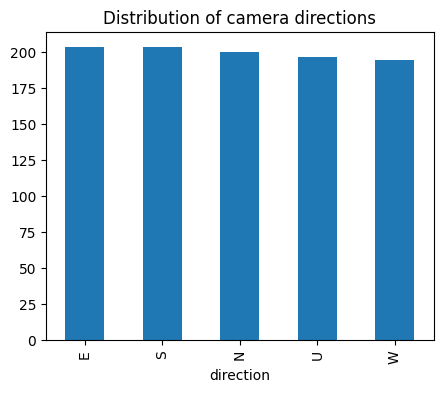

In [7]:
df["direction"].value_counts().plot(kind="bar", figsize=(5,4))
plt.title("Distribution of camera directions")
plt.show()

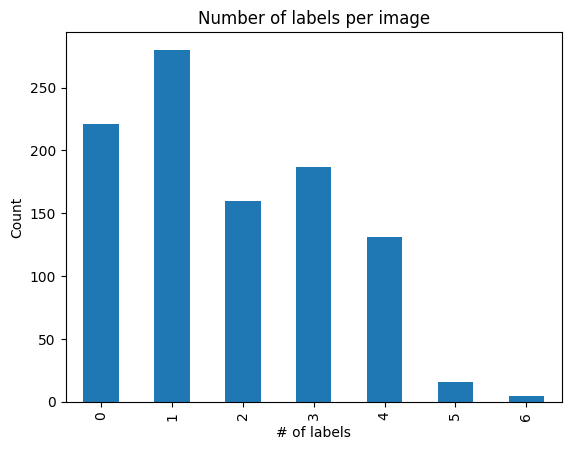

Mean number of labels: 1.795


In [8]:
df["num_labels"] = df[CLOUD_COLS].sum(axis=1)
df["num_labels"].value_counts().sort_index().plot(kind="bar")
plt.title("Number of labels per image")
plt.xlabel("# of labels")
plt.ylabel("Count")
plt.show()
print(f"Mean number of labels: {df['num_labels'].mean()}")

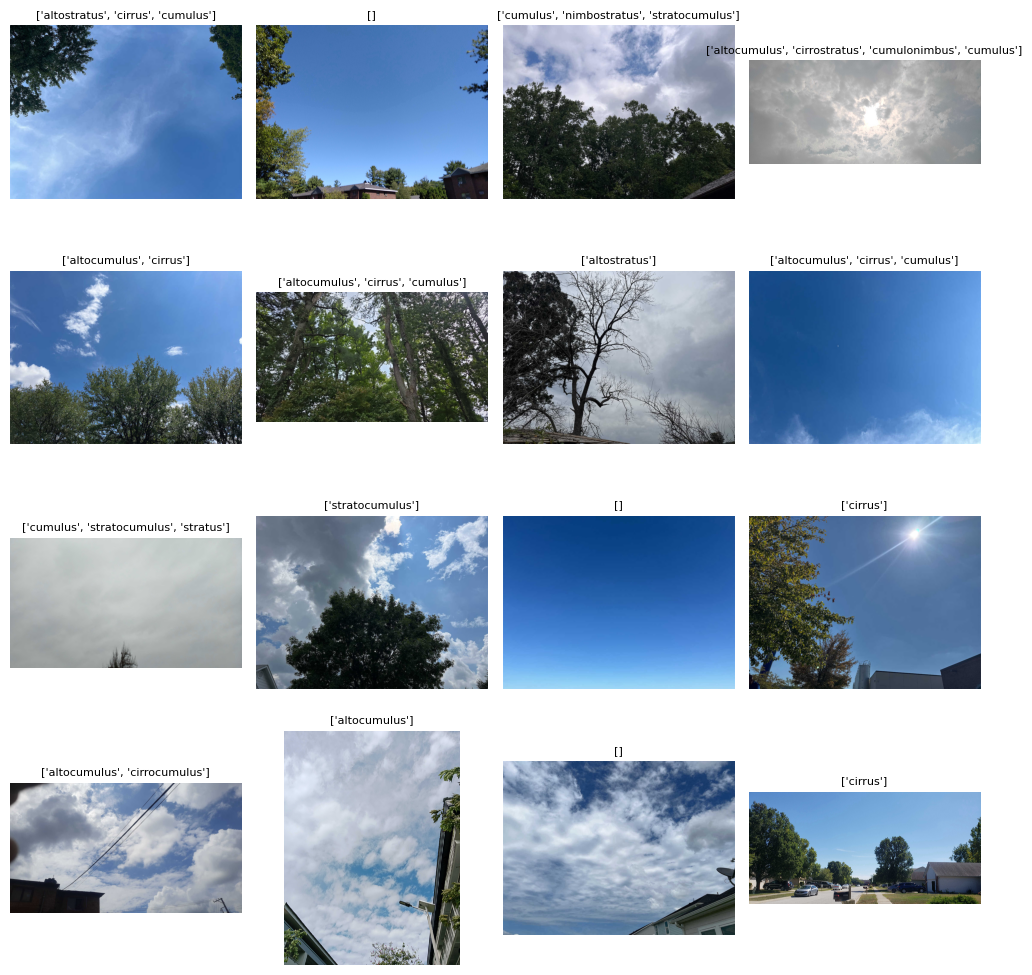

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

n = 4

sample = df.dropna(subset=["local_path"]).sample(n*n, random_state=42)

fig, axes = plt.subplots(n, n, figsize=(10, 10))

for ax, (_, row) in zip(axes.flatten(), sample.iterrows()):
    img = mpimg.imread(f'{BASE_DIR}/{row["local_path"]}')
    ax.imshow(img)
    labels = [c for c in CLOUD_COLS if row[c] == 1]
    ax.set_title(f"{labels}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

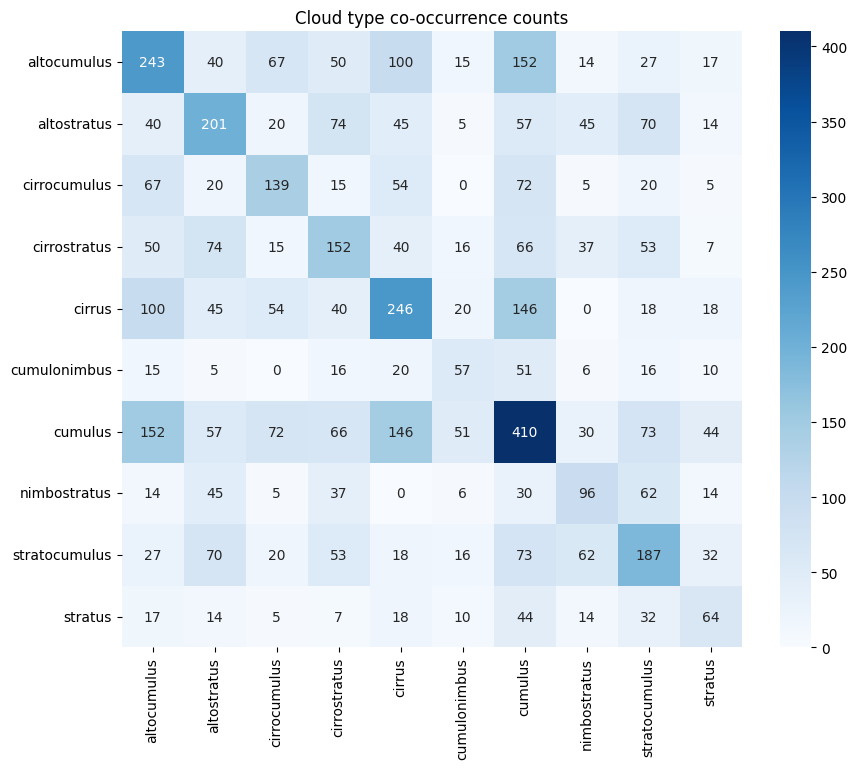

In [10]:
import seaborn as sns
import numpy as np

co_occurrence = np.dot(df[CLOUD_COLS].T, df[CLOUD_COLS])

co_matrix = pd.DataFrame(co_occurrence, index=CLOUD_COLS, columns=CLOUD_COLS)

plt.figure(figsize=(10,8))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Cloud type co-occurrence counts")
plt.show()

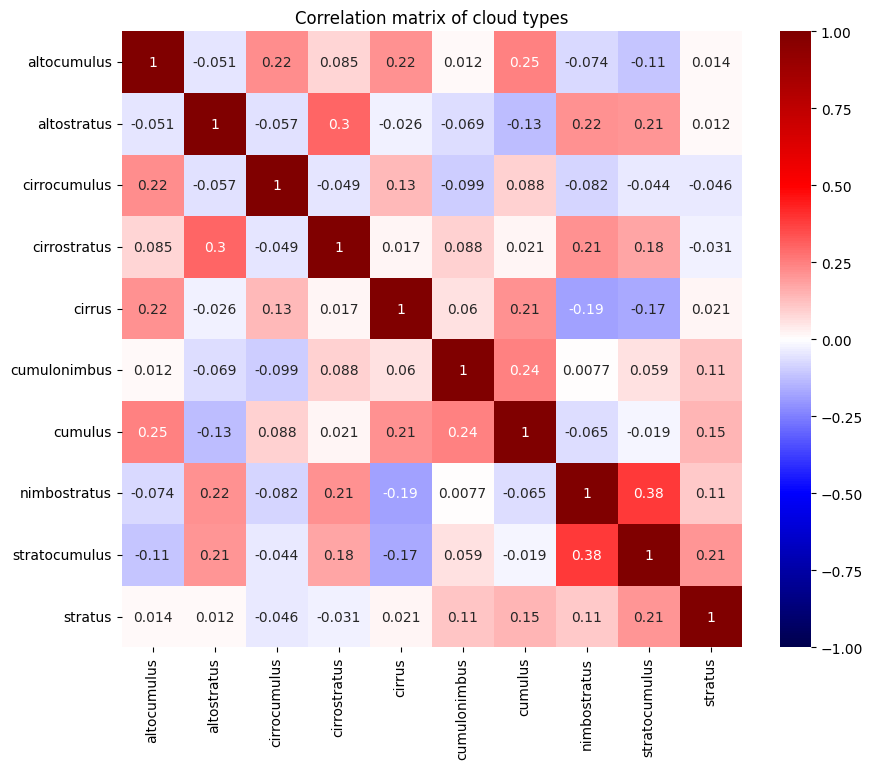

In [11]:
import matplotlib.pyplot as plt

corr = df[CLOUD_COLS].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="seismic", vmin=-1, vmax=1)
plt.title("Correlation matrix of cloud types")
plt.show()

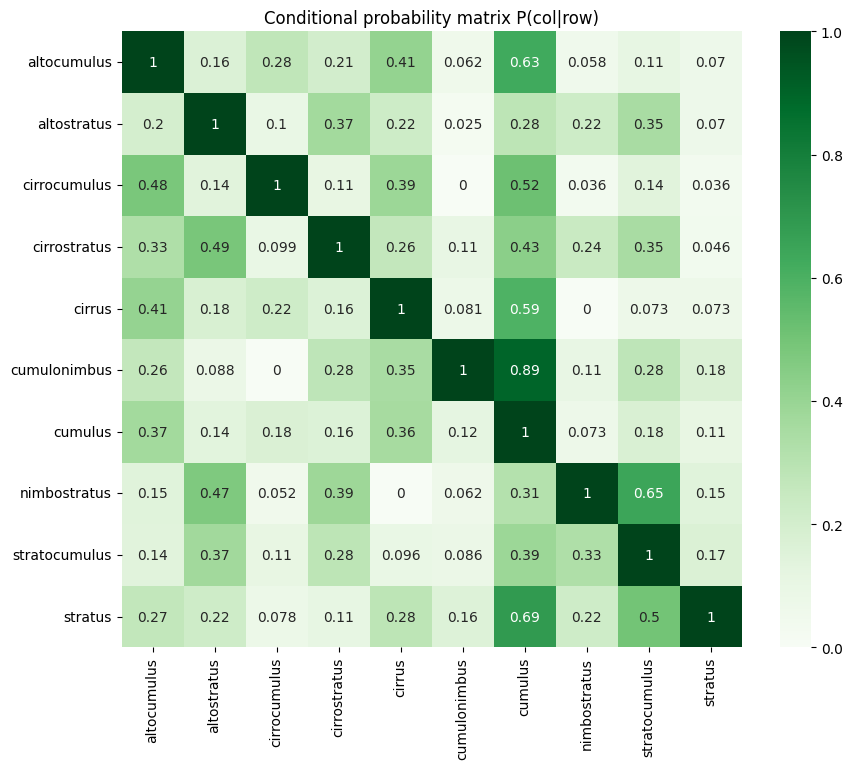

In [12]:
import pandas as pd

# compute conditional probability P(B|A)
def conditional_prob(df, A, B):
    A_present = df[df[A] == 1]
    if len(A_present) == 0:
        return 0
    return (A_present[B] == 1).mean()

cond_probs = pd.DataFrame(index=CLOUD_COLS, columns=CLOUD_COLS, dtype=float)

for A in CLOUD_COLS:
    for B in CLOUD_COLS:
        cond_probs.loc[A, B] = conditional_prob(df, A, B)

plt.figure(figsize=(10,8))
sns.heatmap(cond_probs, annot=True, cmap="Greens")
plt.title("Conditional probability matrix P(col|row)")
plt.show()

In [151]:
##############################
#                            #
#                            #
#                            #
# NO LOCAL IMAGES DATAFRAME  #
#                            #
#                            #
#                            #
##############################

df_all = pd.read_csv(f'{DATA_PROCESSED}/main_no_images.csv')

num_pics = {}
for _, row in df_all.iterrows():
    user_id = row['user_id']
    num_pics[user_id] = num_pics.get(user_id, 0) + 1

# keys = list(user_dict.keys())
# keys.sort(key=lambda k: user_dict[k], reverse=True)

# trusted_user_total = 0
# for key in keys:
#     print(key, user_dict[key])
    # if user_dict[key] > cutoff:
    #     trusted_user_total += user_dict[key]

# print(f"cutoff: {cutoff}")
# print(f"total photos by trusted users: {trusted_user_total}")
# print(f"total photos: {sum(user_dict.values())}")



# for key in keys:
    # print(key, user_dict[key])

trusted_users = [id for id in df_all['user_id'] if 300 > num_pics[id]]

df_trusted = df_all[df_all['user_id'].isin(trusted_users)]
df_untrusted = df_all[~df_all['user_id'].isin(trusted_users)]

print(f"Trusted users: {len(df_trusted)}")
print(f"Untrusted users: {len(df_untrusted)}")

Trusted users: 18879
Untrusted users: 3229


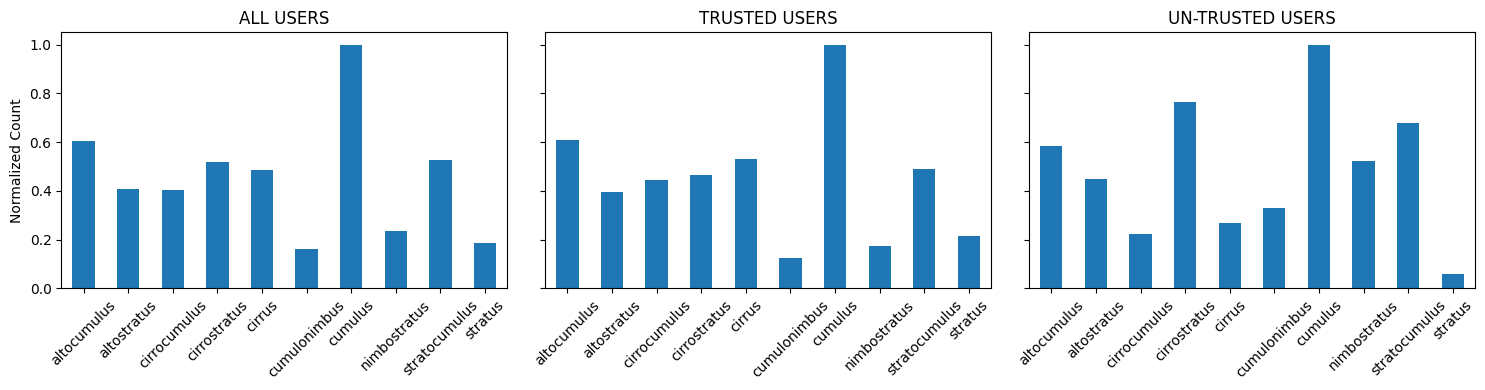

In [152]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

def plot_norm(df, title, ax):
    counts = df[CLOUD_COLS].sum()
    counts = counts / counts.max()
    counts.plot(kind="bar", ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Normalized Count")
    ax.tick_params(axis="x", rotation=45)

# ALL USERS
plot_norm(df_all, "ALL USERS", axes[0])

# TRUSTED USERS
plot_norm(df_trusted, "TRUSTED USERS", axes[1])

# UN-TRUSTED USERS
plot_norm(df_untrusted, "UN-TRUSTED USERS", axes[2])

plt.tight_layout()
plt.show()

In [153]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

def sample_user_subs(user_id, df=df_all, n=4, cloud_cols=CLOUD_COLS, url_col="photo_url"):
    df_user = df[df["user_id"] == user_id].dropna(subset=[url_col])

    if df_user.empty:
        print(f"No submissions with images found for user_id {user_id}")
        return

    sample_size = min(n*n, len(df_user))
    sample = df_user.sample(sample_size)

    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, sample.iterrows()):
        try:
            response = requests.get(row[url_col], timeout=5)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, "Image load error", ha="center", va="center")
            print(f"Error loading {row[url_col]}: {e}")

        labels = [c for c in cloud_cols if row[c] == 1]
        ax.set_title(", ".join(labels), fontsize=7)
        ax.axis("off")

    for ax in axes[len(sample):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def sample_df_subs(df, n=4, cloud_cols=CLOUD_COLS, url_col="photo_url"):
    sample_size = min(n*n, len(df))
    sample = df.sample(sample_size)

    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, sample.iterrows()):
        try:
            response = requests.get(row[url_col], timeout=5)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, "Image load error", ha="center", va="center")
            print(f"Error loading {row[url_col]}: {e}")

        labels = [c for c in cloud_cols if row[c] == 1]
        ax.set_title(", ".join(labels), fontsize=7)
        ax.axis("off")

    for ax in axes[len(sample):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

def user_corr_matrix(user_id, df=df_all, cloud_cols=CLOUD_COLS):
    df_user = df[df["user_id"] == user_id]

    if df_user.empty:
        print(f"No submissions found for user_id {user_id}")
        return

    corr = df_user[cloud_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="seismic", vmin=-1, vmax=1)
    plt.title(f"Correlation matrix of cloud types (user {user_id})")
    plt.show()

    return corr

def df_corr_matrix(df, cloud_cols=CLOUD_COLS):
    corr = df[cloud_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="seismic", vmin=-1, vmax=1)
    plt.title(f"Correlation matrix of cloud types for a df")
    plt.show()

    return corr

In [95]:
# sample_user_subs(59830782)

In [97]:
# corr_user = user_corr_matrix(user_id=59830782, df=df_all)

In [98]:
# import matplotlib.pyplot as plt

# corr = df_all[CLOUD_COLS].corr()

# plt.figure(figsize=(10,8))
# sns.heatmap(corr, annot=True, cmap="seismic", vmin=-1, vmax=1)
# plt.title("Correlation matrix of cloud types (main_no_images)")
# plt.show()

In [142]:
# sample_df_subs(df_trusted)

In [143]:
# sample_df_subs(df_untrusted)

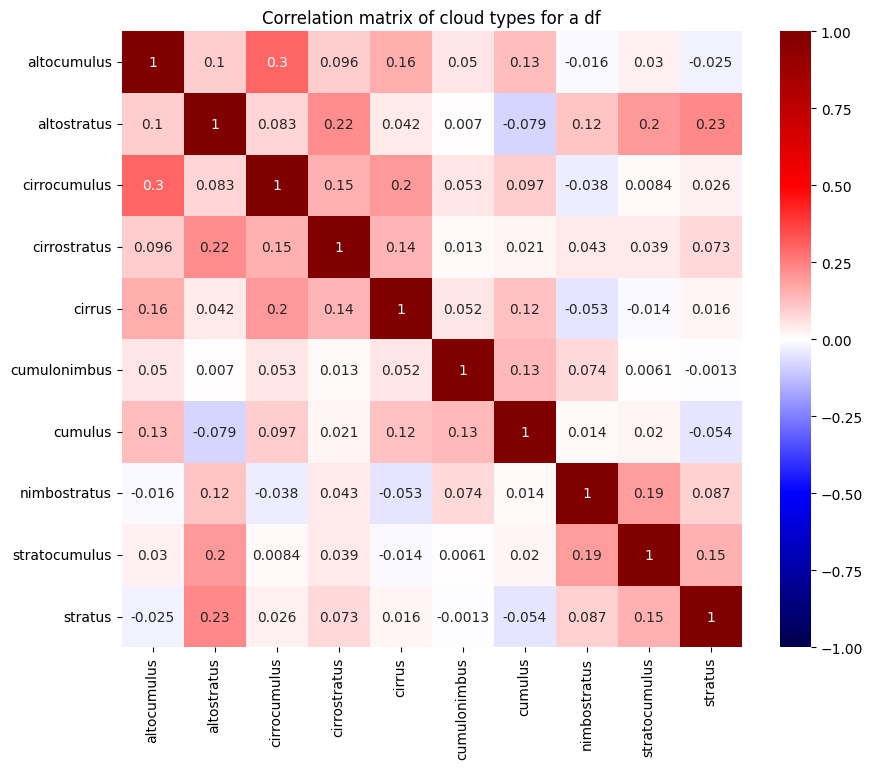

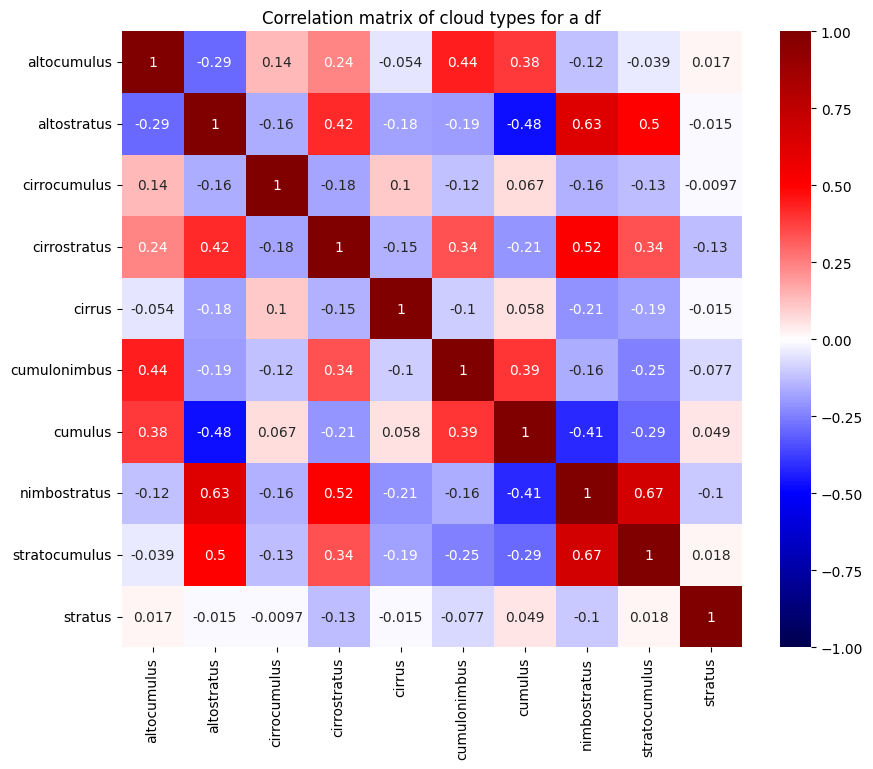

,altocumulus,altostratus,cirrocumulus,cirrostratus,cirrus,cumulonimbus,cumulus,nimbostratus,stratocumulus,stratus
altocumulus,1.000000,-0.291103,0.135815,0.235460,-0.053937,0.441714,0.383426,-0.120512,-0.039358,0.017154
altostratus,-0.291103,1.000000,-0.161510,0.416753,-0.180323,-0.189061,-0.475475,0.629712,0.504908,-0.014992
cirrocumulus,0.135815,-0.161510,1.000000,-0.175380,0.103657,-0.118004,0.066877,-0.156119,-0.126942,-0.009746
cirrostratus,0.235460,0.416753,-0.175380,1.000000,-0.152110,0.339086,-0.206868,0.515376,0.341818,-0.125798
cirrus,-0.053937,-0.180323,0.103657,-0.152110,1.000000,-0.101384,0.058104,-0.214277,-0.185361,-0.015020
cumulonimbus,0.441714,-0.189061,-0.118004,0.339086,-0.101384,1.000000,0.392009,-0.159204,-0.247253,-0.077152
cumulus,0.383426,-0.475475,0.066877,-0.206868,0.058104,0.392009,1.000000,-0.414869,-0.291228,0.049105
nimbostratus,-0.120512,0.629712,-0.156119,0.515376,-0.214277,-0.159204,-0.414869,1.000000,0.669314,-0.103654
stratocumulus,-0.039358,0.504908,-0.126942,0.341818,-0.185361,-0.247253,-0.291228,0.669314,1.000000,0.018285
stratus,0.017154,-0.014992,-0.009746,-0.125798,-0.015020,-0.077152,0.049105,-0.103654,0.018285,1.000000


In [154]:
df_corr_matrix(df_trusted)
df_corr_matrix(df_untrusted)

In [155]:
def df_imgs_per_cloud(df, cloud_cols=CLOUD_COLS):
    label_counts = df[CLOUD_COLS].sum().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    label_counts.plot(kind="bar")
    plt.title("Number of images per cloud type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

def df_labels_per_img(df, cloud_cols=CLOUD_COLS):
    df["num_labels"] = df[CLOUD_COLS].sum(axis=1)
    df["num_labels"].value_counts().sort_index().plot(kind="bar")
    plt.title("Number of labels per image")
    plt.xlabel("# of labels")
    plt.ylabel("Count")
    plt.show()
    print(f"Mean number of labels: {df['num_labels'].mean()}")

In [147]:
# df_imgs_per_cloud(df_all)
# df_labels_per_img(df_all)

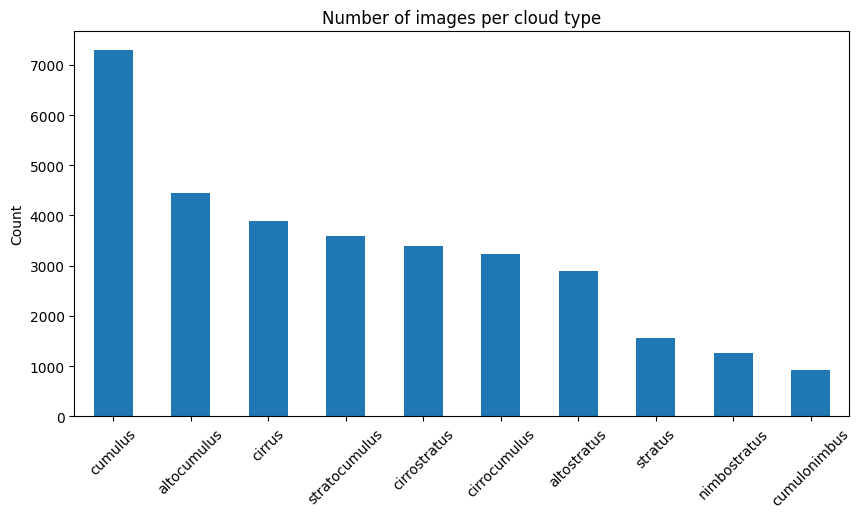

/tmp/ipython-input-1616692646.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_labels"] = df[CLOUD_COLS].sum(axis=1)


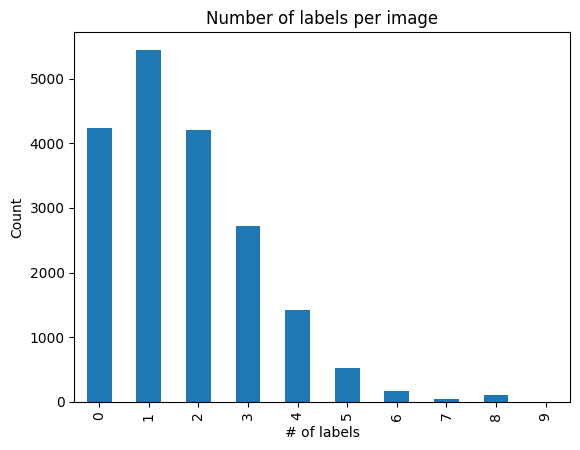

Mean number of labels: 1.721648392393665


In [156]:
df_imgs_per_cloud(df_trusted)
df_labels_per_img(df_trusted)

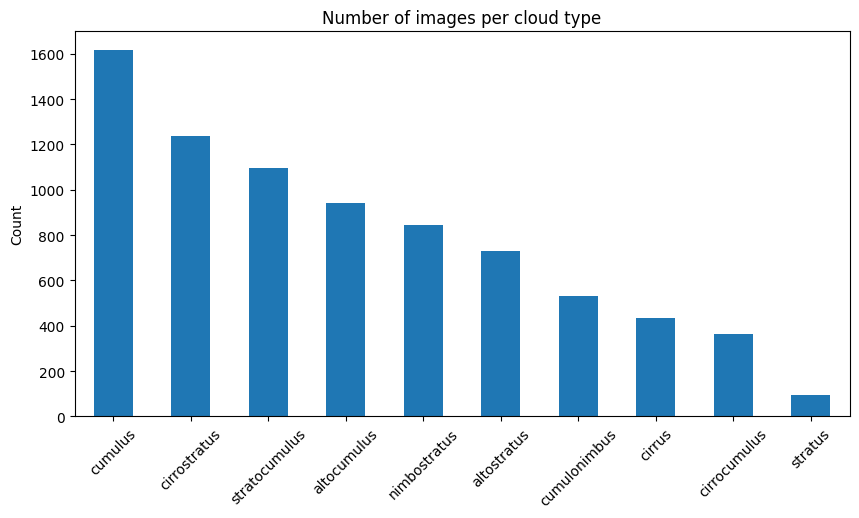

/tmp/ipython-input-1616692646.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_labels"] = df[CLOUD_COLS].sum(axis=1)


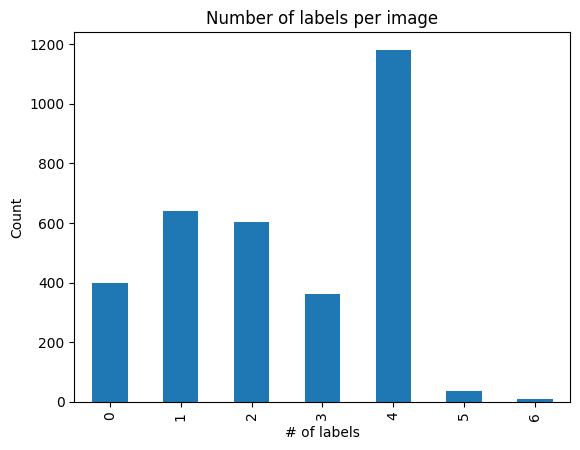

Mean number of labels: 2.443480953855683


In [157]:
df_imgs_per_cloud(df_untrusted)
df_labels_per_img(df_untrusted)

In [ ]:
!git status